# **Load Data**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as ex
import plotly.graph_objects as go
import Pipeline as pipe
import seaborn as sea




In [2]:
data = pd.read_csv("google_5yr_one.csv")
df = pd.DataFrame(data)

#check column
print(df.columns)

#check len
print("dataset size: ",len(df))

Index(['Date', 'Close', 'High', 'Low', 'Open', 'Volume'], dtype='object')
dataset size:  1256


# EDA: Data Characterstics

In [3]:
df.describe()

,Date,Close,High,Low,Open,Volume
count,1255,1256,1256,1256,1256,1256
unique,1255,1238,1256,1256,1256,1250
top,2025-06-02,105.46577453613281,169.8699951171875,167.38999938964844,167.83999633789062,22288000
freq,1,3,1,1,1,3


In [4]:
# change type before view describe
header = df.columns
new_df = df
new_df['Date'] = pd.to_datetime(new_df['Date'])
for i in header[1:]:
      new_df[i] = pd.to_numeric(new_df[i], errors='coerce')
print(new_df.dtypes)

Date      datetime64[ns]
Close            float64
High             float64
Low              float64
Open             float64
Volume           float64
dtype: object


In [5]:
# view data
new_df.describe()

,Date,Close,High,Low,Open,Volume
count,1255,1255.000000,1255.000000,1255.000000,1255.000000,1.255000e+03
mean,2022-11-30 12:32:42.071713280,127.343522,128.767640,125.894397,127.286213,3.211913e+07
min,2020-06-04 00:00:00,67.802834,69.567407,67.260929,67.693363,9.312000e+06
25%,2021-08-31 12:00:00,102.415359,103.588002,101.102139,102.211330,2.333280e+07
50%,2022-11-29 00:00:00,128.465805,130.137811,126.953037,128.635000,2.882800e+07
75%,2024-02-29 12:00:00,147.319427,148.956410,146.023874,147.533393,3.675800e+07
max,2025-06-02 00:00:00,206.142593,206.811821,202.576693,203.156027,1.274901e+08
std,NaN,31.589957,31.873115,31.332366,31.626389,1.354981e+07


In [6]:
# check rows and columns
print(new_df.shape)

(1256, 6)


In [7]:
# check missing data
pd.date_range(start="2020-06-04 00:00:00", end="2025-06-02 00:00:00", freq="B") # b means business days
full_date_range = pd.date_range(start="2020-06-04 00:00:00", end="2025-06-02 00:00:00", freq="B")
dates_in_data=pd.to_datetime(data['Date'])

missing_dates = set(full_date_range) - set(dates_in_data)
actual_holidays = pipe.check_holidays()
# check_holidays is a function that return a list of holiats

if missing_dates:
    print(f'Missing {len(missing_dates)} dates')
    
print(f"{len(actual_holidays)} is official market holidays")




Missing 48 dates
48 is official market holidays


 all missing dates are holidays, 
 no ffill or bfill needed for the dataset

# EDA: Data Visualization

> Scatter Plot: High Low Range

> can define： percentage, moving avg (20 days), high_low_breakout (exceed threshold may be a signal)

In [8]:
new_df = pipe.hl_range_features(df)
breakout_threshold = new_df['hl_range_pct'].quantile(0.95) # top 5% quantile of hl_range_pct
new_df['hl_breakout'] = new_df['hl_range_pct'] > breakout_threshold

fig = ex.scatter(
    new_df,
    x='Date',
    y='hl_range_pct',
    title='High Low Range Percentage Over Time',
    color='hl_breakout',  # Use the column directly for color
    color_discrete_map={True: 'red', False: 'green'}
)
fig.add_scatter(
    x=new_df['Date'],
    y=new_df['hl_range_ma'],
    mode='lines',
    name='20-day Moving Avg',
    line=dict(color='blue')
)
fig.show()


>Scatter plot: Open Close Range

In [9]:
# flactuation can be viewed by the size of the data points
w_df=pipe.open_close_range_feature(new_df).dropna()
sizes = np.abs(w_df['open_close'])*100
fig = ex.scatter(w_df,x='Date',y= 'open_close',title='Date vs Open Close Range', size=sizes)

fig.show()

> scatter 2: color markup for Open Close Range

In [10]:
w_df=pipe.open_close_range_feature(new_df).dropna() 
w_df['label'] = ['Increase' if c >=0 else 'Drop' for c in w_df['open_close']]

fig = ex.scatter(w_df,x='Date',y= 'open_close',title='Date vs Open Close Range', color='label',
                 color_discrete_map={'Increase': 'green', 'Drop':'red'})

fig.show()

> Candlestick Chart

In [11]:
candle_figure = go.Figure(data=[go.Candlestick(
    x=df['Date'],
    open=df['Open'],
    high=df['High'],
    low=df['Low'],
    close=df['Close']
    
)])

candle_figure.update_layout(
    title_text='Google Stock CandleStick Chart'
)

candle_figure.update_layout(
    xaxis_title='Date',
    yaxis_title='Price',
    xaxis = dict(
        rangeselector = dict(
            buttons=list([
            dict(count=1, label="1m", step="month",stepmode="backward"),
            dict(count=6, label="6m", step="month",stepmode="backward"),
            dict(count=1, label="1y", step="year",stepmode="backward"),
            dict(step="all")
        ])
        ),
        rangeslider=dict(visible=True),
    type="date"
       
    )
     
    )
candle_figure.show()

> Volume Heat Map

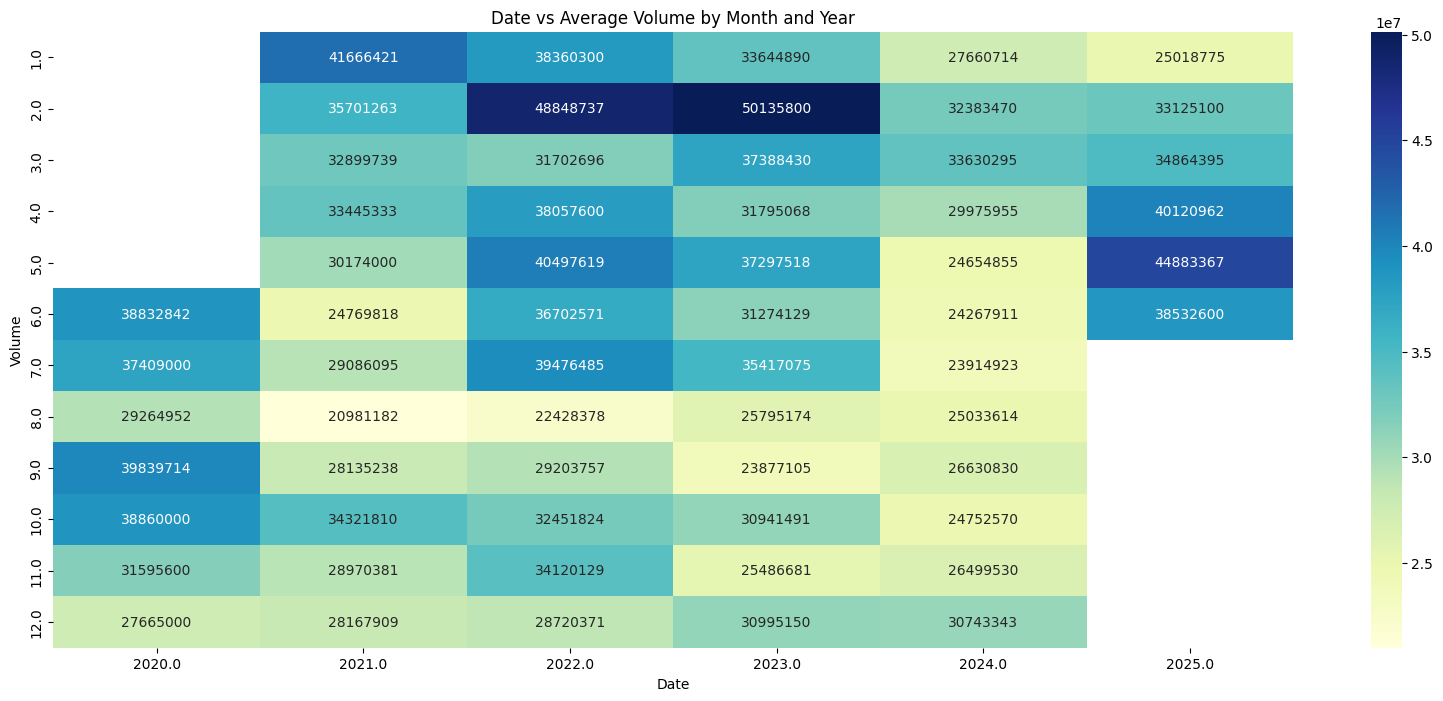

In [12]:
plt.figure(figsize=(20,8))

new_df['Year'] = new_df['Date'].dt.year
new_df['Month']= new_df['Date'].dt.month

pivot_table = new_df.pivot_table(index='Month', columns='Year', values='Volume', aggfunc='mean')
sea.heatmap(pivot_table,cmap='YlGnBu', annot=True, fmt='.0f')

plt.bar(new_df['Date'],new_df['Volume'],color='pink')
plt.xlabel('Date')
plt.ylabel('Volume')
plt.title('Date vs Average Volume by Month and Year')


plt.show()

>Bar chart: Volume Spike Ratio

In [13]:

new_df = pipe.volume_spike(new_df)
threshold = 2.0 # volume is the twice avg value for the past month
spikes = new_df[new_df['volume_spike_ratio'] >threshold]

fig = ex.bar(spikes,'Date','volume_spike_ratio',title='Date vs Volume Spike Ratio > 2')


fig.show()

> Line Chart with marker: to view volume spike with the change of close price

In [14]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=new_df['Date'], y=new_df['Close'], name='Close Price'))
fig.add_trace(go.Scatter(x=spikes['Date'], y=spikes['Close'],
                         mode='markers', name='Volume Spike',
                         marker=dict(color='red', size=10, symbol='star')))

fig.update_layout(title='Price with Volume Spikes Highlighted')
fig.show()

>Area Chart: Rolling Volatility

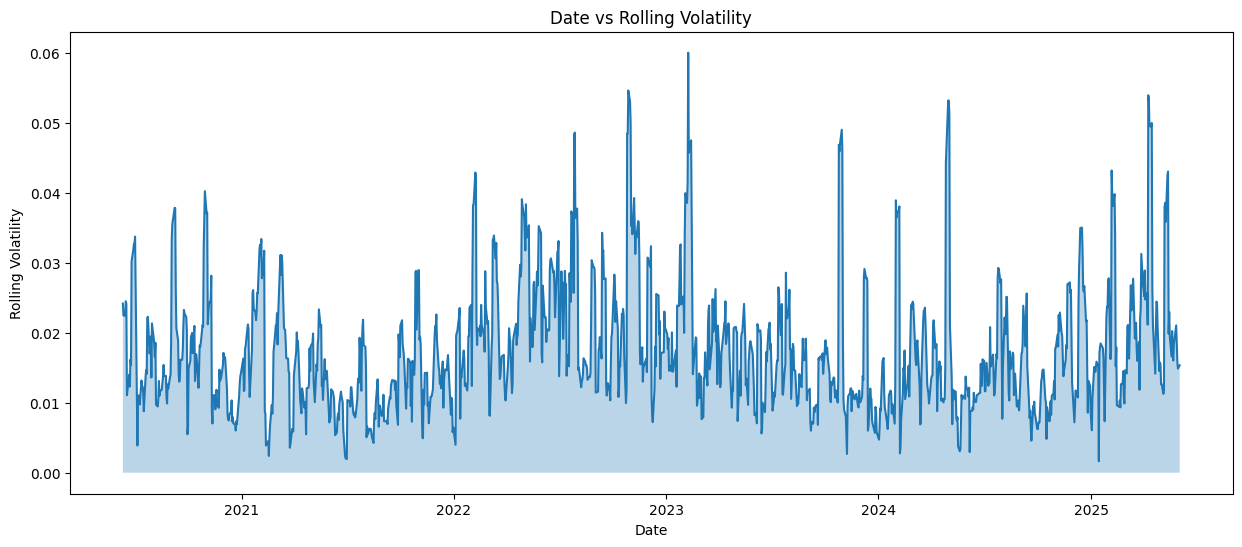

In [15]:
new_df = pipe.rolling_volatility(new_df)
x=new_df['Date']
y=new_df['roll_vola_return']

plt.figure(figsize=(15,6))
plt.plot(x,y,label='Line')
plt.fill_between(x,y,alpha=0.3)

plt.xlabel('Date')
plt.ylabel('Rolling Volatility')
plt.title('Date vs Rolling Volatility')

plt.show()

> Scatter plot: Break Out points

In [16]:
new_df['label'] = new_df['hl_breakout'].apply(lambda c: 'Break' if c else 'Normal')
fig = ex.scatter(new_df,x='Date',y= 'hl_range',title='Break Out', color='label',
                 color_discrete_map={'Break': 'red', 'Normal':'blue'})
fig.show()



>Bar Chart: Close Price Increment with dropdown menu(year) and slider (month)

In [17]:
colors = ['green' if c >= o else 'red' for c, o in zip(new_df['Close'], new_df['Open'])]
fig = go.Figure()
fig.add_trace(
    go.Bar(
        x=new_df['Date'],
        y=new_df['Close'],
        marker_color=colors
    )
)
fig.update_layout(
    title_text='Closing Price (Green = Up, Red = Down)',
    width=1000,
    height=600,
    template="plotly_white",
)
# steps for each month
steps_m = []
new_df['YearMonth'] = new_df['Date'].dt.to_period('M')
months = new_df['YearMonth'].dropna().unique()
for month in months:
    visible = (new_df['YearMonth'] == month)
    step = dict(
        method='restyle',
        args=[{
            "x":[new_df.loc[visible, 'Date']],
            "y":[new_df.loc[visible, 'Close']],
             "marker.color": [list(pd.Series(colors)[visible])]},
              {"title":f"Month:{month}"}],
         label=str(month)
    )
    steps_m.append(step)
sliders_m= [dict(
    active=0,
    pad={"t": 50},
    steps=steps_m
)]
# dropdown for each year
years = new_df['Date'].dt.year.dropna().unique()
fig.update_layout(
    updatemenus=[
        dict(
            buttons=[
                dict(
                    label=str(year),
                    method='update',
                    args=[{
                        "x":[new_df.loc[new_df['Date'].dt.year == year, 'Date']],
                        "y":[new_df.loc[new_df['Date'].dt.year == year, 'Close']],
                    }
                    ]
                )
                for year in years
                
            ],
            direction="down",
            pad={"r": 10, "t": 10},
                    showactive=True,
            x=0.1,
            xanchor="left",
            y=1.1,
            yanchor="top"
        )
    ],
    
   sliders=sliders_m
)


fig.show()


Close price vs Date

C:\Users\littl\AppData\Local\Temp\ipykernel_7400\73840020.py:4: UserWarning:

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



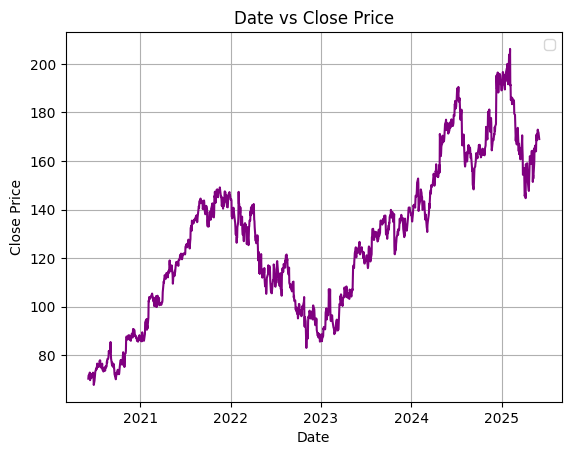

In [18]:
plt.plot(new_df['Date'], new_df['Close'],  linestyle='-',color='purple')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True)
plt.title('Date vs Close Price')
plt.show()


# **Data Preprosessing**

# Clean Null Data


In [19]:
df = new_df
df = pipe.clean_data(df)
print(len(df))
df.describe()

1255


,Date,Close,High,Low,Open,Volume,hl_range,hl_range_ma,hl_range_pct,Year,Month,volume_spike_ratio,roll_vola_price,log_return,roll_vola_return
count,1255,1255.000000,1255.000000,1255.000000,1255.000000,1.255000e+03,1255.000000,1236.000000,1255.000000,1255.000000,1255.000000,1236.000000,1251.000000,1254.000000,1250.000000
mean,2022-11-30 12:32:42.071713280,127.343522,128.767640,125.894397,127.286213,3.211913e+07,2.873243,2.871213,0.022949,2022.411952,6.555378,1.008439,2.096118,0.000699,0.017652
min,2020-06-04 00:00:00,67.802834,69.567407,67.260929,67.693363,9.312000e+06,0.751898,1.406923,0.005726,2020.000000,1.000000,0.276414,0.157141,-0.099924,0.001642
25%,2021-08-31 12:00:00,102.415359,103.588002,101.102139,102.211330,2.333280e+07,1.888968,2.328648,0.015439,2021.000000,4.000000,0.770767,1.170892,-0.009645,0.011086
50%,2022-11-29 00:00:00,128.465805,130.137811,126.953037,128.635000,2.882800e+07,2.527915,2.725470,0.020782,2022.000000,7.000000,0.922511,1.762747,0.001420,0.015841
75%,2024-02-29 12:00:00,147.319427,148.956410,146.023874,147.533393,3.675800e+07,3.493552,3.335465,0.027522,2024.000000,10.000000,1.128136,2.668986,0.011486,0.021459
max,2025-06-02 00:00:00,206.142593,206.811821,202.576693,203.156027,1.274901e+08,17.160004,5.869501,0.113357,2025.000000,12.000000,3.291752,9.618440,0.097348,0.060076
std,NaN,31.589957,31.873115,31.332366,31.626389,1.354981e+07,1.512238,0.864471,0.010859,1.497478,3.431710,0.382553,1.331412,0.019627,0.009211


# Set Target

In [20]:
df['target'] = df['Close'].shift(-1)
df=df.dropna(subset=['target'])

C:\Users\littl\AppData\Local\Temp\ipykernel_7400\43544308.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



# Split Data

In [21]:
lvl_1_train_df, lvl_1_test_df = pipe.test_train_split(df)
train_df, validate_df, test_df = pipe.split_data(lvl_1_train_df)
print(len(train_df)) # 0.7
print(len(validate_df)) # 0.15
print(len(test_df)) # 0.15

613
132
132


# Fill Rolling Null Values 

In [22]:
# check null
if train_df.isna().sum().sum() == 0:
    print('train_df no null')
else:
    print(train_df.isna().sum())
if validate_df.isna().sum().sum() == 0:
    print('validate_df no null')
else:
    print(validate_df.isna().sum())
if test_df.isna().sum().sum() == 0:
    print('test_df no null')
else:
    print(test_df.isna().sum())


Date                   0
Close                  0
High                   0
Low                    0
Open                   0
Volume                 0
hl_range               0
hl_range_ma           19
hl_range_pct           0
hl_breakout            0
Year                   0
Month                  0
volume_spike_ratio    19
roll_vola_price        4
log_return             1
roll_vola_return       5
label                  0
YearMonth              0
target                 0
dtype: int64
validate_df no null
test_df no null


In [23]:
train_df['log_return'] = train_df['log_return'].fillna(0)

fill_items = {
    #col name: (dependency, type)
    'hl_range_ma':('hl_range','mean'),
    'volume_spike_ratio':('Volume','mean'),
    'roll_vola_price':('Close','std'),
    'roll_vola_return':('log_return','std')
}

for target_col, (dependencies, types) in fill_items.items():
    if types == 'mean':
        if target_col == 'volume_spike_ratio':
            train_df[target_col] = train_df[target_col].fillna(
                 train_df[dependencies] / train_df[dependencies].expanding(min_periods=1).mean()
            )
        else: # hl_range_ma
             train_df[target_col] = train_df[target_col].fillna(
                train_df[dependencies].expanding(min_periods=1).mean()
            )
    elif types == 'std': # roll_vola_price or roll_vola_return
        train_df[target_col] = train_df[target_col].fillna(
                train_df[dependencies].expanding(min_periods=2).std()
            )
        train_df[target_col] = train_df[target_col].fillna(0)
        
# min period = 2 , 2 data points --> has differences hence std return result, a valid value
train_df
            
            

C:\Users\littl\AppData\Local\Temp\ipykernel_7400\2093809178.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\littl\AppData\Local\Temp\ipykernel_7400\2093809178.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\littl\AppData\Local\Temp\ipykernel_7400\2093809178.py:14: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas

,Date,Close,High,Low,Open,Volume,hl_range,hl_range_ma,hl_range_pct,hl_breakout,Year,Month,volume_spike_ratio,roll_vola_price,log_return,roll_vola_return,label,YearMonth,target
1,2020-06-04,70.378517,71.723094,69.965992,71.497169,26982000.0,1.757102,1.757102,0.024966,False,2020.0,6.0,1.000000,0.000000,0.000000,0.000000,Normal,2020-06,71.658401
2,2020-06-05,71.658401,71.970910,70.046107,70.445200,42642000.0,1.924803,1.840953,0.026861,False,2020.0,6.0,1.224922,0.905015,0.018022,0.012744,Normal,2020-06,72.057487
3,2020-06-08,72.057487,72.105256,70.885091,70.974667,33878000.0,1.220164,1.634023,0.016933,False,2020.0,6.0,0.981952,0.877146,0.005554,0.009230,Normal,2020-06,72.258530
4,2020-06-09,72.258530,73.040793,71.774842,71.918162,33624000.0,1.265951,1.542005,0.017520,False,2020.0,6.0,0.980821,0.844163,0.002786,0.007951,Normal,2020-06,72.886528
5,2020-06-10,72.886528,73.288104,72.371990,72.727787,31762000.0,0.916114,1.416827,0.012569,False,2020.0,6.0,0.940327,0.933580,0.008653,0.006948,Normal,2020-06,69.761475
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
609,2022-11-01,90.039528,95.573070,89.940005,94.995828,47161400.0,5.633065,3.131527,0.062562,True,2022.0,11.0,1.403996,2.307323,-0.043687,0.050008,Break,2022-11,86.556183
610,2022-11-02,86.556183,90.746150,86.466607,90.507294,57038300.0,4.279543,3.189749,0.049442,True,2022.0,11.0,1.614265,3.600520,-0.039455,0.035297,Break,2022-11,83.033020
611,2022-11-03,83.033020,86.108313,82.943444,85.909268,61288000.0,3.164869,3.231549,0.038116,False,2022.0,11.0,1.643898,5.264281,-0.041555,0.036738,Normal,2022-11,86.168037
612,2022-11-04,86.168037,86.227749,83.311691,84.993652,51124900.0,2.916059,3.266383,0.033842,False,2022.0,11.0,1.329189,4.212907,0.037061,0.034110,Normal,2022-11,88.068947


# Normalization

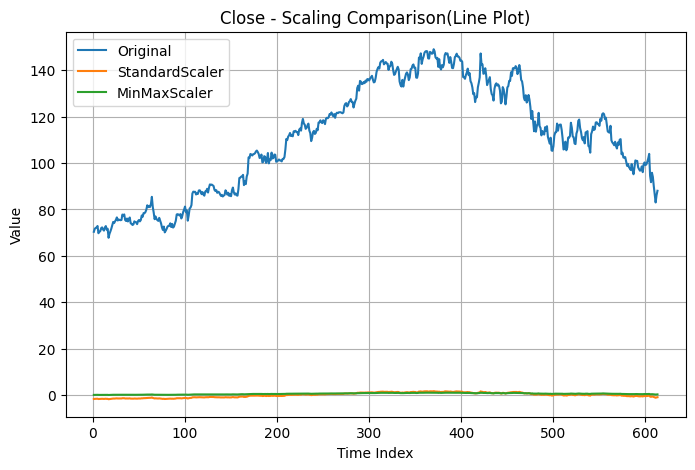

In [24]:
# standard scaler vs min max scaler
from sklearn.preprocessing import StandardScaler, MinMaxScaler

feature = 'Close' # single feature as string
original = train_df[feature].values.reshape(-1, 1)  # reshape to 2D array

std_scaler = StandardScaler().fit_transform(original)
minmax_scaler = MinMaxScaler(feature_range=(0,1)).fit_transform(original)

scaled_df = pd.DataFrame(
    {
        'Original': train_df[feature],
        'StandardScaler': std_scaler.flatten(), # convert to 1D
        'MinMaxScaler': minmax_scaler.flatten()
    }
)

scaled_df.plot(title=f'{feature} - Scaling Comparison(Line Plot)', figsize=(8,5))
plt.xlabel('Time Index')
plt.ylabel('Value')
plt.grid(True)
plt.show()


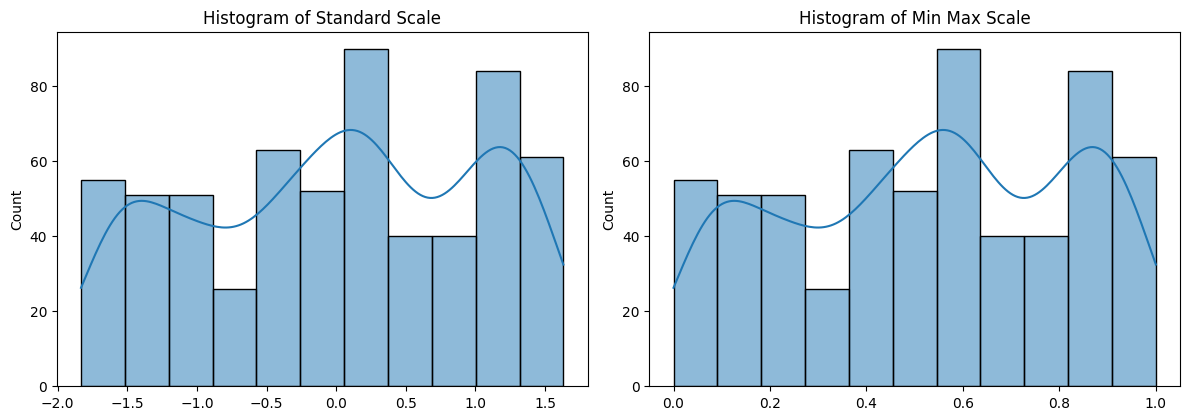

In [25]:
plt.figure(figsize=(12,8))

plt.subplot(2,2,1)
sea.histplot(std_scaler.flatten(),kde=True)
plt.title('Histogram of Standard Scale')

plt.subplot(2,2,2)
sea.histplot(minmax_scaler.flatten(),kde=True)
plt.title('Histogram of Min Max Scale')

plt.tight_layout()
plt.show()

In [26]:
# comparison above not much different, we will need to use MAE, MSE, R2 to measure
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, MinMaxScaler

features = [
    'Close',                 
    'High',                   
    'Low',                    
    'Open',                   
    'Volume',                 
    'hl_range',               
    'hl_range_ma',           
    'hl_range_pct',                       
    'volume_spike_ratio',    
    'roll_vola_price',       
    'log_return',             
    'roll_vola_return',
]

target = 'target'
X_train = train_df[features] # train_df[12 cols]
y_train = train_df[target] # train_df['target']
X_val = validate_df[features] # validate_df[12 cols]
Y_val = validate_df[target] # validate_df['target']

std_scaler = StandardScaler()
X_train_std = std_scaler.fit_transform(X_train)
X_val_std = std_scaler.transform(X_val)

minmax_scaler = MinMaxScaler()
X_train_mm = minmax_scaler.fit_transform(X_train)
X_val_mm = minmax_scaler.transform(X_val)

model_std= LinearRegression()
model_std.fit(X_train_std,y_train)
pred_std = model_std.predict(X_val_std)

model_mm = LinearRegression()
model_mm.fit(X_train_mm,y_train)
pred_mm = model_mm.predict(X_val_mm)

pipe.metrics_performance(Y_val,pred_std,"StandardScaler")
pipe.metrics_performance(Y_val,pred_mm,"MinMaxScaler")




StandardScaler - MAE:1.7030, RMSE:5.0981, R2:0.9197
MinMaxScaler - MAE:1.7030, RMSE:5.0981, R2:0.9197


Both have same performance
 >Note that Linear Regression has lower sentivity on scaler: influenced by overall distribution patterns
 
 >Consider MinMaxScaler FOR sigmoid [logistic regression] or visualization


#   XGBOOST

XGBoost - MAE:1.9370, RMSE:6.7151, R2:0.8942


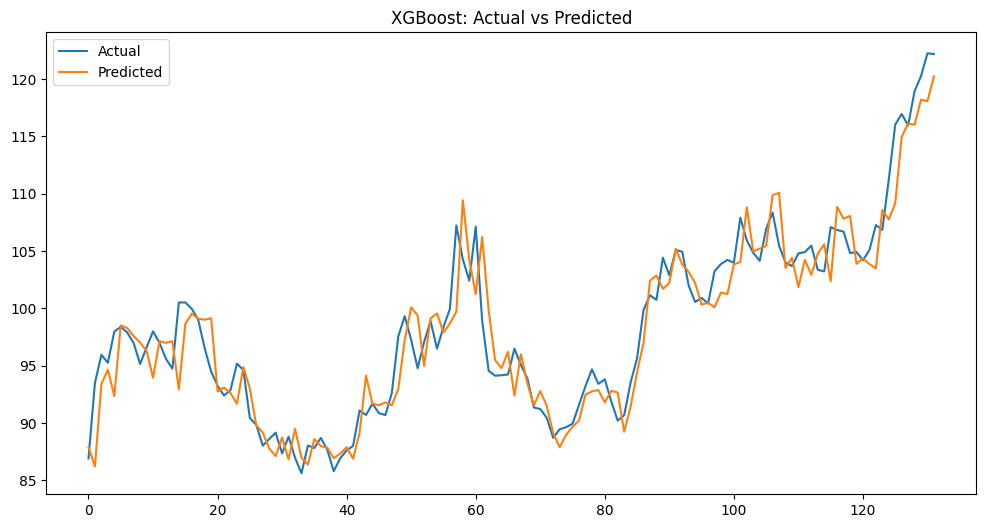

In [27]:
# XGBOOST
from xgboost import XGBRegressor
xgboost_model = XGBRegressor()
# fit with stardard scaler
xgboost_model.fit(X_train_std,y_train)
predict_xgboost = xgboost_model.predict(X_val_std)
pipe.metrics_performance(Y_val,predict_xgboost,'XGBoost')


plt.figure(figsize=(12,6))
plt.plot(Y_val.values, label='Actual')
plt.plot(predict_xgboost, label='Predicted')
plt.legend()
plt.title('XGBoost: Actual vs Predicted')
plt.show()






In [28]:
# ETS - Holt Linear
from statsmodels.tsa.holtwinters import ExponentialSmoothing
